In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
import sys
import warnings
warnings.filterwarnings('ignore')



In [3]:
homedir = os.getenv("HOME")
sys.path.append(homedir+'/github/APPSS/')
from a100sdss import ks, anderson
sys.path.append(homedir+'/github/LCS/python/')
from LCScommon import *


Running on coma


# Strategy

### Paper 1

We compared the size ratio of infall galaxies to the core galaxies.

### Paper 2

* With the addition of the large field sample, we can compare the SFR distribution of the core galaxies with the field galaxies.


* we should use a mass-matched subsample of the field galaxies - draw a sample 10 times?  or draw 10 for each galaxy?  either way is probably fine.  We will compare the SFR distribution of the field and core.

* but how?  we really want to compare the core vs simulated galaxies in the SFR-Mstar plane.

* or could we just start with a mass-matched sample, decrease the SFRs at some rate, and then compare with the core?

* what does fraction of suppressed galaxies vs Mstar look like for the core vs infall vs field?

# How does SF MS evolve

$$ logSFR = \alpha(z) (logMstar - 10.5) + \beta(z)  $$



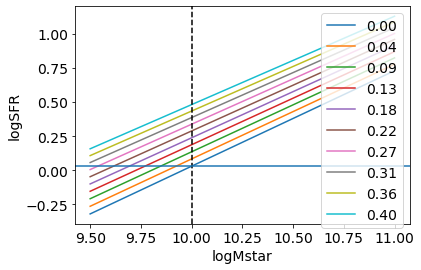

In [4]:
redshift = np.linspace(0,.4,10)
logMstar = np.linspace(9.5,11,100)
#redshift = np.array([0,.4])
#logMstar = 10
plt.figure()
for z in redshift:
    alpha = 0.7 - 0.13*z
    beta = 0.38 + 1.14*z - 0.19*z**2
    logSFR = alpha*(logMstar-10.5)+beta
    label = '{:.2f}'.format(z)
    #print(z,logSFR)
    plt.plot(logMstar,logSFR,label=label)
plt.legend()
plt.xlabel('logMstar')
plt.ylabel('logSFR')
plt.axvline(x=10,ls='--',c='k')
plt.axhline(y=.03)

# Modeling that we did spring/summer 2021

Previously, we took the field galaxies, assigned a random infall time, and then let the SFRs decline exponentially according to some timescale tau.  We also included a boost factor.
This is not correct, because we are using the field at $z=0$ as the starting point, but we should instead be using the field at the epoch of infall.

We figured out how to link (SFR, Mstar) of the present field galaxies with their (SFR_infall,Mstar_infall).  Instead of trying to work backward, we created a grid of galaxies with a range of stellar masses and SFRs (relative to the MS), corresponding to the max allowable infall time that we will assign (e.g. for tmax=3Gyr).  We then evolve these galaxies by stepping forward in time.  

The details of how we evolve a galaxy:  TBD

Once we have the stellar mass and SFR at the time of infall, we can let the SFR decline according to a timescale $\tau$ (we loop over a range of potential values for $\tau$) to simulate environmental quenching.

$$ SFR_{sim-core} = SFR_{infall}~ e^{-t_{infall}/\tau} $$

and mass evolves according to 

$$ M_{sim-core} = M_{infall} + \int_{t_{infall}}^0 SFR_{infall}~ e^{-t/\tau}~ f(t) dt $$

where $f(t)$ is the fraction of mass retained when the stellar pop has reached an age of t years.  We model this using the prescription from Poggianti+XX.

$$ f(t) = 1.749 - 0.125 log_{10}(t/yr) $$






# Getting SFR and Mstar at the time of infall

* we generate a grid of models that link the Mstar and SFR of galaxies through time
* this lets us link the $z=0$ field galaxies with their progenitors at the time of infall.
* we are assigning random infall times, so the grid allows the user to find the galaxy that is closest in terms of M(z=0), SFR(z=0) and infall time.
* I originally ran this for tmax = 3 Gyr.  Rerunning for tmax = 5 Gyr.  This should cover the full range of reasonable infall times (longer than 5 Gyr is probably not realistic).

* the program creates forward_model_sfms.fits in the current directory.  I am moving to ~/research/LCS/sfr_modeling/ before running so that the output file is stored there.

* this didn't complete with a certain combo of time steps.

In [ ]:
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr-mstar-forward-model.py --tmax 3 --ntimestep 50

In [ ]:
os.chdir('/home/rfinn/research/LCS/sfr_modeling/')
%run /home/rfinn/github/LCS/python/sfr-mstar-forward-model.py --tmax 5 --ntimestep 50

In [31]:
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs.py

Welcome!


In [6]:
def plot_sfrp_tau(tau,p_sfr):
    plt.figure()
    plt.plot(tau,p_sfr,'k.',alpha=.1)
    plt.axhline(y=.05)
    plt.xlabel(r'$\tau (Gyr)$')
    plt.ylabel('SFR p value')

Welcome!


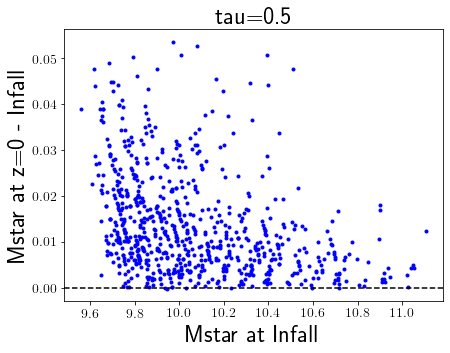

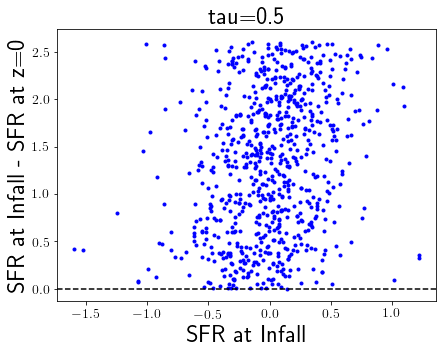

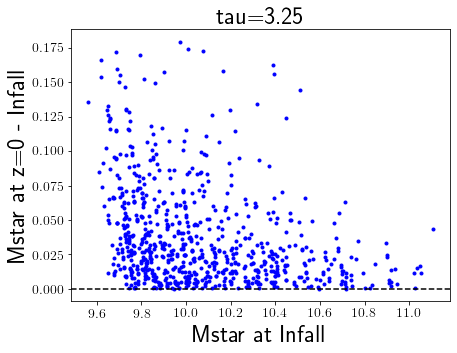

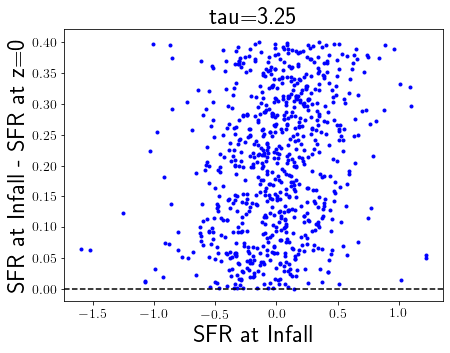

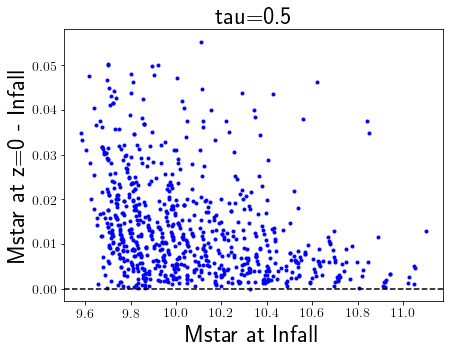

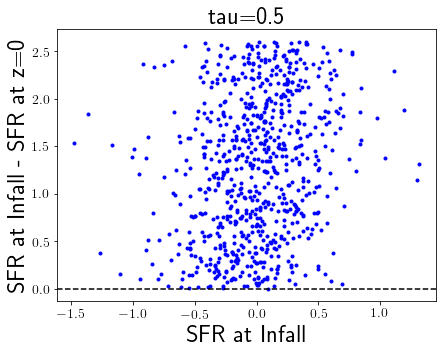

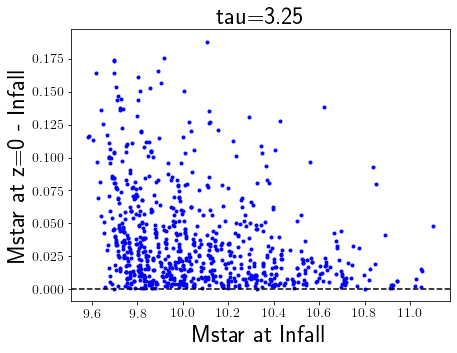

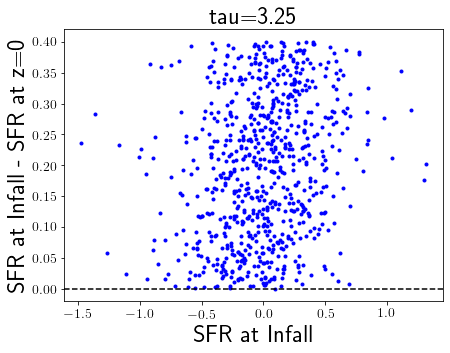

In [32]:
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs.py
t = run_sim(taumax=6,nstep_tau=2,nrandom=1,nmassmatch=5,tmax=3,debug=True)

In [33]:
all_tau,all_boost,all_p_sfr,all_p_dsfr,fquench_sfr = t

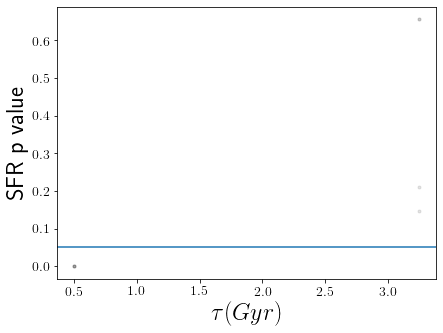

In [34]:
plot_sfrp_tau(all_tau,all_p_sfr)

# tmax = 4 Gyr

In [ ]:
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs.py
t4 = run_sim(taumax=6,nstep_tau=24,nrandom=10,nmassmatch=10,tmax=4,debug=False)
all_tau4,all_boost4,all_p_sfr4,all_p_dsfr4,fquench_sfr4 = t4


# tmax = 3 Gyr

In [ ]:
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs.py
t3 = run_sim(taumax=6,nstep_tau=24,nrandom=10,nmassmatch=10,tmax=3,debug=False)
all_tau3,all_boost3,all_p_sfr3,all_p_dsfr3,fquench_sfr3 = t3


# tmax = 2 Gyr

In [ ]:
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs.py
t2 = run_sim(taumax=6,nstep_tau=24,nrandom=10,nmassmatch=10,tmax=2,debug=False)
all_tau2,all_boost2,all_p_sfr2,all_p_dsfr2,fquench_sfr2 = t2


# tmax = 1 Gyr

In [ ]:
%run /home/rfinn/github/LCS/python/LCSsimulate-infall-sfrs.py
t1 = run_sim(taumax=6,nstep_tau=24,nrandom=10,nmassmatch=10,tmax=1,debug=False)
all_tau1,all_boost1,all_p_sfr1,all_p_dsfr1,fquench_sfr1 = t1
